In [1]:
import glob
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import pytorch_lightning as pl
from torchvision import models,transforms
import torchvision.transforms.functional as TF
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import CSVLogger
import matplotlib.pyplot as plt

## Loading data

In [2]:
# Input data
subject_ids = np.loadtxt("selected_samples_subset.txt", dtype=str)
left_hippo_dir = "LeftCSV_subset/"
left_hippo_files = glob.glob(left_hippo_dir+"*")
right_hippo_dir = "RightCSV_subset/"
right_hippo_files = glob.glob(right_hippo_dir+"*")
labels = pd.read_csv("adni_subset.csv",names=['ID','AD']) 

In [3]:
class HippocampusDataset(Dataset):
    def __init__(self, left_hippo_files, right_hippo_files, labels=None):
        self.left_hippo = [pd.read_csv(f, header=None, sep=" ").values for f in left_hippo_files]
        self.right_hippo = [pd.read_csv(f, header=None, sep=" ").values for f in right_hippo_files]
        self.labels = labels['AD'] if labels is not None else None

    def __len__(self):
        return len(self.left_hippo)

    def __getitem__(self, idx):
        left = self.left_hippo[idx].astype(np.float32)   # shape: (15000, 7)
        right = self.right_hippo[idx].astype(np.float32) # shape: (15000, 7)

        ##########################################################
        # 1. Concatenate the left and right hippocampus data along the feature dimension => (15000, 14)
        # 2. Transpose to get (14, 15000)
        # 3. Reshape each feature into (14, 150, 100)
        # 4. Convert to torch tensor and normalize per feature channel
        ##########################################################
        pass


        ##########################################################
        # END OF YOUR CODE
        ##########################################################

        if self.labels is not None:
            label = self.labels.iloc[idx]
            return sample, label
        else:
            return sample

In [4]:
data_df = pd.DataFrame({
    'ID': subject_ids,
    'LeftFile': left_hippo_files,
    'RightFile': right_hippo_files
})

# Merge data and labels on SubjectID
merged_df = pd.merge(data_df, labels, on='ID', how='inner')  # Keep only subjects with labels

# Now extract the filtered lists
filtered_left_files = merged_df['LeftFile'].tolist()
filtered_right_files = merged_df['RightFile'].tolist()

unique_labels = sorted(set(labels['AD']))
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
labels['AD'] = [label_to_index[label] for label in labels['AD']]

# Split into training and validation sets
train_left, test_left, train_right, test_right, train_labels, test_labels = train_test_split(
    filtered_left_files, filtered_right_files, labels, test_size=0.2, random_state=42
)
train_left, val_left, train_right, val_right, train_labels, val_labels = train_test_split(
    train_left, train_right, train_labels, test_size=0.2, random_state=42
)

# Create Datasets and DataLoaders
train_dataset = HippocampusDataset(train_left, train_right, train_labels)
val_dataset = HippocampusDataset(val_left, val_right, val_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

test_dataset = HippocampusDataset(test_left, test_right, test_labels)
test_loader = DataLoader(test_dataset, batch_size=32)

## visualize some samples

In [ ]:
print(f"The training set contain {len(train_dataset)} samples.")
print(f"Each sample has shape {train_dataset[0][0].shape}.")

Each sample is an image(150*100) with 14 Channels/Features from left and right hippocampus.
We can visualize one sample 

In [ ]:
example_rd_tensor = train_dataset[0][0][0]  # shape: (150, 100)
# Convert to NumPy
radial_distance = example_rd_tensor.cpu().numpy() 

# Then plot as before
plt.imshow(radial_distance, origin='lower', cmap='jet', aspect='auto')
plt.colorbar(label="Radial Distance")
plt.title("First Feature (Radial Distance) in 2D")
plt.xlabel("Horizontal Index")
plt.ylabel("Vertical Index")
plt.show()

## Naive CNN model

### First we create a trainer

In [5]:
class Trainer(pl.LightningModule):
    def __init__(self, model = None):
        super(Trainer, self).__init__()
        self.model = model
        self.criterion = nn.CrossEntropyLoss()
    
    def forward(self, x):  
        return self.model(x)
        
    def training_step(self, batch, batch_idx):
        data, labels = batch
        outputs = self(data)
        loss = self.criterion(outputs, labels)
        preds = torch.argmax(outputs, dim=1)
        acc = (preds == labels).float().mean()
        self.log('train_loss', loss)
        self.log('train_acc', acc)
        return loss

    def validation_step(self, batch, batch_idx):
        data, labels = batch
        outputs = self(data)
        loss = self.criterion(outputs, labels)
        preds = torch.argmax(outputs, dim=1)
        acc = (preds == labels).float().mean()
        self.log('val_loss', loss)
        self.log('val_acc', acc)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)

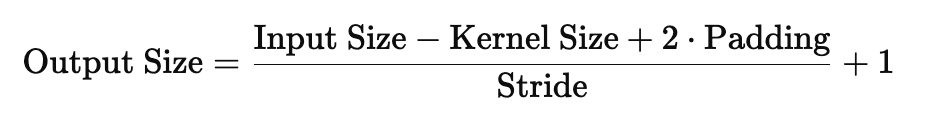

In [9]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        ##########################################################
        # 1) Three 2D convolutional layers
        # 2) A MaxPool2d layer self.pool
        # 3) A Dropout layer self.dropout with probability 0.5
        # 4) Two fully connected layers
        #    -> Remember to compute in_features for self.fc1 based on
        #       the output shape after the Conv+Pool layers.
        ##########################################################
        pass

        ##########################################################
        # END OF YOUR CODE
        ##########################################################

    def forward(self, x):
        """
        Forward pass:
        x shape = [batch_size, 14, 150, 100]
        """
        # 1) First conv + ReLU + pool
        x = F.relu(self.conv1(x))  
        x = self.pool(x)           

        # 2) Second conv + ReLU + pool
        x = F.relu(self.conv2(x))  
        x = self.pool(x)           

        # 3) Third conv + ReLU + pool
        x = F.relu(self.conv3(x))  
        x = self.pool(x)          

        # Flatten
        x = x.view(x.size(0), -1)  
        x = self.dropout(x)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x.squeeze()  

### Sanity Check of simple CNN

You can use this to make sure the dimension of matrix match. To ensure the dimensions of matrices match and debug potential mismatches, you can add print statements to check the shape of each tensor in the forward step of your model.

In [ ]:
x = torch.randn(1, 14, 150, 100)
simple_cnn = SimpleCNN()
simple_cnn(x)

### Helper function for us to visualize the training process

In [6]:
class FinalPlotCallback(pl.Callback):
    def __init__(self):
        super().__init__()
        self.train_losses = []
        self.val_losses = []

    def on_train_epoch_end(self, trainer, pl_module):
        # Append training and validation loss at the end of each epoch
        train_loss = trainer.callback_metrics.get("train_loss")
        if train_loss:
            self.train_losses.append(train_loss.cpu().detach().item())
        
        val_loss = trainer.callback_metrics.get("val_loss")
        if val_loss:
            self.val_losses.append(val_loss.cpu().detach().item())

    def on_train_end(self, trainer, pl_module):
        # Plot the losses at the end of training
        plt.figure(figsize=(10, 5))
        plt.plot(self.train_losses, label="Train Loss", marker="o")
        plt.plot(self.val_losses, label="Validation Loss", marker="o")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training and Validation Loss Over Epochs")
        plt.legend()
        plt.grid(True)
        plt.show()

### Train the Naive CNN model

You can add techniques to prevent overfitting, such as early stopping.

In [ ]:
model = Trainer(model=SimpleCNN())
# Trainer
trainer =  pl.Trainer(max_epochs=50, callbacks=[FinalPlotCallback()]) # You may check the documents  
# Training
trainer.fit(model, train_loader, val_loader)

### Testing the Naive CNN model

### Finish the testing helper function

In [12]:
def testing(model):
    # Inference on Test Set
    model.eval()
    test_label = test_labels['AD']
    test_preds = []
    with torch.no_grad():
        for batch in test_loader:
            data, _ = batch  # Unpack the batch; labels are ignored
            outputs = model(data)
            predictions = torch.argmax(outputs, dim=1)
            test_preds.extend(predictions.cpu().numpy())
    ##########################################################
    # TODO: Import the necessary evaluation metrics from sklearn.metrics:
    # - accuracy_score
    # - precision_score
    # - recall_score
    # - f1_score
    # - roc_auc_score
    #
    # Then, compute the following metrics using `test_label` and `test_preds`:
    # 1. Accuracy
    # 2. Precision (use 'weighted' average)
    # 3. Recall (use 'weighted' average)
    # 4. F1-Score (use 'weighted' average)
    # 5. ROC-AUC (use 'weighted' average and 'ovr' for multi_class)
    #
    # Finally, print out each metric with four decimal places in the specified format.
    ##########################################################
    # Replace "pass" statement with your code
    pass

    ##########################################################
    # END OF YOUR CODE
    ##########################################################

In [ ]:
testing(model)

# Try some class CNN structures

We can experiment with modern CNN architectures such as ResNet and DenseNet. These models can be loaded from torch.hub, and some layers may need to be modified to ensure compatibility. 

Hint: Specifically, ensure that the input layer matches the shape of your data and the output layer corresponds to the number of classes in your task.

You can feel free to google or ask chatGPT for the answer.

In [ ]:
VGG16 = torch.hub.load('pytorch/vision:v0.19.0', 'vgg16', pretrained=False)
print(VGG16)

In [ ]:
##########################################################
# TODO: You need to find a way to modify layers in VGG16 to match the input shape of your data and the number of output classes.
##########################################################
# Replace "pass" statement with your code
pass

##########################################################
# END OF YOUR CODE
##########################################################
print(VGG16_new)

You can expect an accuracy around 70%

In [ ]:
model = Trainer(model=VGG16_new)
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    min_delta=0.00,
    patience=20,
    verbose=True,
    mode='min'
)
# Trainer
trainer =  pl.Trainer(max_epochs=30, callbacks=[early_stop_callback,FinalPlotCallback()])
# Training
trainer.fit(model, train_loader, val_loader)

In [ ]:
testing(model)